
Failure Rate Variability
Neighbors for 5 vnodes: 9.53937032162
0.125 12.00 0.000093 0.001115
0.250 24.00 0.000186 0.004459
0.500 48.00 0.000372 0.017834
1.000 96.00 0.000743 0.071323
2.000 192.00 0.001485 0.285185


Vnode Variability under 7.92744799594e-09 machine failure rate
1      2.00 6144   0.002338
2      3.94 3120   0.002337
3      5.84 2457   0.002732
4      7.71 2457   0.003605
5      9.54 2457   0.004459
6      11.33 2457   0.005295
7      13.08 2457   0.006114
8      14.80 2457   0.006916
9      16.48 2457   0.007701
10     18.12 2457   0.008469
11     19.73 2457   0.009222
12     21.31 2457   0.009958
13     22.85 2457   0.010679
14     24.36 2457   0.011385
15     25.84 2457   0.012077
256    94.58 2457   0.044172


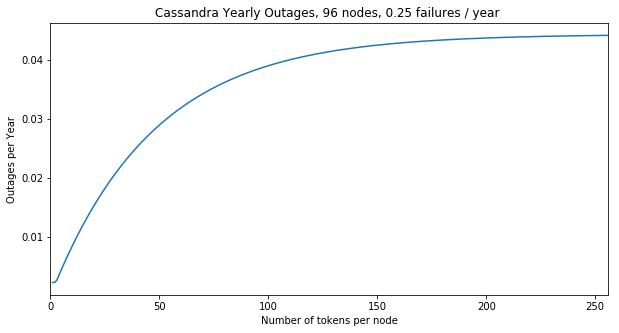

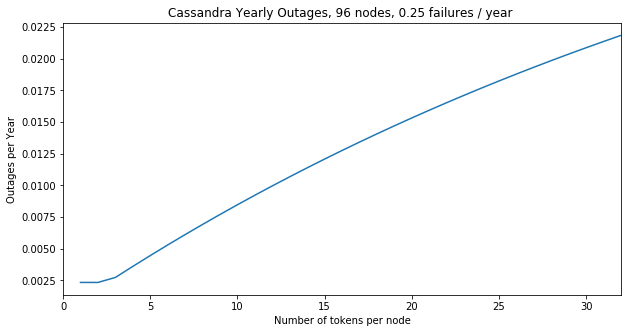

In [85]:
from __future__ import print_function
import math
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  


def _comb(n, k):
    return math.factorial(n) / (math.factorial(k) * math.factorial(n - k))

# Boils down to "If I pick nodes (rf - 1) * vnode times, how many
# distinct nodes will I have in expectation
# https://math.stackexchange.com/questions/72223/finding-expected-number-of-distinct-values-selected-from-a-set-of-integers
def num_neighbors(n, v, rf):
    k = v * (rf - 1)
    n = n - 1
    return sum((-1)**i * _comb(k, i + 1) * n**(-i) for i in range(0, k-1))

def p_outage_given_failure(recovery, num_neighbors, rate):
    x =  math.exp(-1 * recovery * num_neighbors * rate)
    return 1 - x

def exp_failures(num_nodes, rate, year):
    return num_nodes * rate * year

def recovery_c(size, bw_in, bw_out, neighbors):
    return int(size / (min(bw_in, neighbors * bw_out)))

num_nodes = 96
vnodes = 5
rf = 3
# 1000 gigabytes
node_dataset_mb = 300 * 1024
# MB/s
bw_in = 125
bw_out = 25

year = 60.0*60*24*365
arate = 0.25 / year


print("\nFailure Rate Variability")
neighbors = num_neighbors(num_nodes, vnodes, rf)
print("Neighbors for {0} vnodes: {1}".format(vnodes, neighbors))
recovery = recovery_c(node_dataset_mb, bw_in, bw_out, neighbors)

for i in (0.125, 0.25, 0.5, 1, 2):
    rate = i / (year)
    failures = exp_failures(num_nodes, rate, year)
    probability = p_outage_given_failure(recovery, neighbors, rate)

    p = "{0:.3f} {1:.2f} {2:.6f} {3:.6f}".format(
        i, failures, probability, failures * probability
    )
    print(p)

print("\n\nVnode Variability under {0} machine failure rate".format(arate))
num_vnodes = range(1, 257)
outages = []
for vnode in num_vnodes:
    neighbors = num_neighbors(num_nodes, vnode, rf)
    recovery = recovery_c(node_dataset_mb, bw_in, bw_out, neighbors)
    failures = exp_failures(num_nodes, arate, year)
    probability = p_outage_given_failure(recovery, neighbors, arate)
    p = "{0: <6} {1:.2f} {2: <6} {3:.6f}".format(
        vnode, neighbors, recovery, failures * probability
    )
    if vnode < 16 or vnode > 255:
        print(p)
    outages.append(failures * probability)
    
plt.figure(figsize=(10,5))
plt.title("Cassandra Yearly Outages, {0} nodes, {1:.2f} failures / year ".format(num_nodes, arate * year))
plt.ylabel("Outages per Year")
plt.xlabel("Number of tokens per node")
plt.xlim(0, 256)
plt.plot(num_vnodes, outages)

plt.figure(figsize=(10,5))
plt.title("Cassandra Yearly Outages, {0} nodes, {1:.2f} failures / year ".format(num_nodes, arate * year))
plt.ylabel("Outages per Year")
plt.xlabel("Number of tokens per node")
plt.xlim(0, 32)
plt.plot(num_vnodes[:32], outages[:32])